In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline


In [36]:
spark = SparkSession.builder.appName("PowerPrediction").getOrCreate()
df = spark.read.csv(
    "household_power_consumption_cleaned.csv",
    header=True,
    inferSchema=True
)

In [37]:
df.printSchema()

root
 |-- Global_active_power: double (nullable = true)
 |-- Global_reactive_power: double (nullable = true)
 |-- Voltage: double (nullable = true)
 |-- Global_intensity: double (nullable = true)
 |-- Sub_metering_1: double (nullable = true)
 |-- Sub_metering_2: double (nullable = true)
 |-- Sub_metering_3: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- label: double (nullable = true)



In [38]:
feature_cols = [
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

In [39]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

lr = LinearRegression(
    featuresCol="scaled_features",
    labelCol="label"
)

pipeline = Pipeline(stages=[assembler, scaler, lr])

In [ ]:
from pyspark.sql import Row

k = 10
splits = df.randomSplit([1.0] * k, seed=42)

evaluator_r2 = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="mae"
)

In [41]:
results = []

for i in range(k):
    test_data = splits[i]

    train_data = None
    for j in range(k):
        if j != i:
            train_data = splits[j] if train_data is None else train_data.union(splits[j])

    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    r2 = evaluator_r2.evaluate(predictions)
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    results.append(
        Row(
            Fold=i + 1,
            TrainSize=train_data.count(),
            TestSize=test_data.count(),
            R2=round(r2, 6),
            RMSE=round(rmse, 6),
            MAE=round(mae, 6)
        )
    )

In [42]:
results_df = spark.createDataFrame(results)
results_df.show(truncate=False)


+----+---------+--------+--------+--------+--------+
|Fold|TrainSize|TestSize|R2      |RMSE    |MAE     |
+----+---------+--------+--------+--------+--------+
|1   |472887   |52712   |0.936317|0.292586|0.111471|
|2   |472934   |52665   |0.938441|0.288512|0.110318|
|3   |473025   |52574   |0.934271|0.296254|0.112469|
|4   |472806   |52793   |0.935232|0.294014|0.111303|
|5   |473038   |52561   |0.934919|0.29546 |0.112157|
|6   |473043   |52556   |0.933326|0.297454|0.111644|
|7   |473397   |52202   |0.937128|0.28962 |0.110637|
|8   |473247   |52352   |0.938284|0.288822|0.110758|
|9   |473153   |52446   |0.934464|0.298166|0.112611|
|10  |472861   |52738   |0.935127|0.296206|0.112053|
+----+---------+--------+--------+--------+--------+



In [43]:
from pyspark.sql.functions import avg, stddev

results_df.select(
    avg("R2").alias("Mean_R2"),
    stddev("R2").alias("Std_R2"),
    avg("RMSE").alias("Mean_RMSE"),
    stddev("RMSE").alias("Std_RMSE"),
    avg("MAE").alias("Mean_MAE"),
    stddev("MAE").alias("Std_MAE")
).show()


+------------------+--------------------+---------+--------------------+-------------------+--------------------+
|           Mean_R2|              Std_R2|Mean_RMSE|            Std_RMSE|           Mean_MAE|             Std_MAE|
+------------------+--------------------+---------+--------------------+-------------------+--------------------+
|0.9357508999999998|0.001730350924587...|0.2937094|0.003630634477761573|0.11154209999999998|7.920338727324461E-4|
+------------------+--------------------+---------+--------------------+-------------------+--------------------+



In [ ]:
#train mô hình độc lập
final_train, final_test = df.randomSplit([0.8, 0.2], seed=999)

final_model = pipeline.fit(final_train)
final_predictions = final_model.transform(final_test)


In [47]:
#đánh giá hiệu suất
final_r2 = evaluator_r2.evaluate(final_predictions)
final_rmse = evaluator_rmse.evaluate(final_predictions)
final_mae = evaluator_mae.evaluate(final_predictions)

print("Final R2:", final_r2)
print("Final RMSE:", final_rmse)
print("Final MAE:", final_mae)


Final R2: 0.9356784186892354
Final RMSE: 0.29300613690718663
Final MAE: 0.11157173351776602


In [64]:
final_model.write().overwrite().save("electric_power_lr_model")


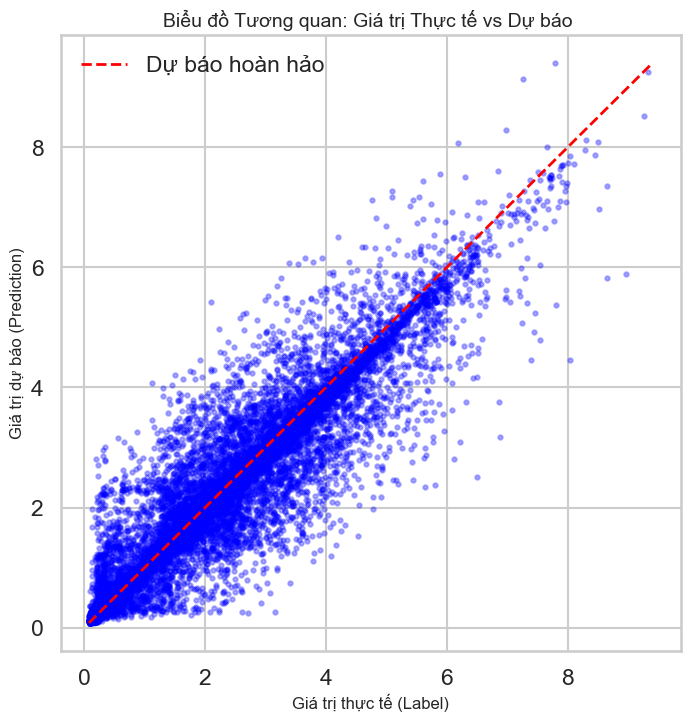

In [63]:
import matplotlib.pyplot as plt

# Lấy mẫu ngẫu nhiên từ kết quả dự báo cuối cùng (final_predictions)
# fraction=0.01 nghĩa là lấy 1% dữ liệu (bạn có thể chỉnh nhỏ hơn nếu dữ liệu quá lớn)
sample_preds = final_predictions.select("label", "prediction").sample(withReplacement=False, fraction=0.5, seed=42).toPandas()

plt.figure(figsize=(8, 8))
plt.scatter(sample_preds['label'], sample_preds['prediction'], alpha=0.3, color='blue', s=10)

# Vẽ đường chéo lý tưởng (Perfect Prediction Line)
min_val = min(sample_preds['label'].min(), sample_preds['prediction'].min())
max_val = max(sample_preds['label'].max(), sample_preds['prediction'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Dự báo hoàn hảo')

plt.title('Biểu đồ Tương quan: Giá trị Thực tế vs Dự báo ', fontsize=14)
plt.xlabel('Giá trị thực tế (Label)', fontsize=12)
plt.ylabel('Giá trị dự báo (Prediction)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()